# Simulated Data Generation in Dymola for Training of the Deep Learning Model Used in Power System (with automation)

Insert the PATH.

In [1]:
import os
import sys
sys.path.insert(0, os.path.join('E:\\', 'Spring2021', 'MnS4CPS', 'Dymola', 'Modelica',
                                'Library', 'python_interface', 'dymola.egg'))

Import all necessary libraries.

In [2]:
from dymola.dymola_interface import DymolaInterface
from dymola.dymola_exception import DymolaException
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import timedelta
import os
import csv
import string
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import MaxPooling1D, Conv1D, GlobalAveragePooling1D, Reshape
from tensorflow.keras.layers import GlobalAveragePooling2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Input, Dropout, Conv2D, BatchNormalization, MaxPool2D, Activation
from tensorflow.keras.models import load_model

Set the parameters of the Dymola Model, including the amplitude, the start time, and the end time of the oscillation event.
Since this is an automation process, we could generate any amount of data. Also set the number of oscillation data and noisy data we want to generate, as represent by osci_data_num and nois_data_num below.

In [3]:
# Set the Parameters of the Dymola model
osci_amp = 4           # Oscillation Amplitude
osci_start = 120       # Oscillation Start Time
osci_end = 200         # Oscillation End Time
simulation_end = 300   # Simulation End Time

# Set the amount of data that need to be generated
osci_data_num = 3000   # Number of oscillation data that needs to be generated
nois_data_num = 3000   # Number of noisy data that needs to be generated

Start to generate data. The array "dataset" stores all the training datas, and the array "labels" stores all the labels for the training datas, namely "1" and "0". Label "0" represents the data is "during oscillation event". Label "1" represents the data is "outside oscillation event".

In [4]:
# Generation Start

dymola = DymolaInterface() # Instantiate the Dymola interface and start Dymola
dymola.openModel("E:/Spring2021/MnS4CPS/Final Project/2018_AmericanModelicaConf_PowerGrid_plus_PowerSystems/Modelica_Models/OpenCPS_D53B/MLTraining/Configurations/SMIB_normal_noise_signalB_test.mo", mustRead = True, changeDirectory = True)
dymola.cd("E:/Spring2021/MnS4CPS/Final Project/") # change the working directory

osci_data_count = 0          # Number of oscillation data that is already generated
nois_data_count = 0          # Number of noisy data that is already generated
stop_generate_osciData = 0   # Set to 1 if enough oscillation data is generated
stop_generate_noisData = 0   # Set to 1 if enough noisy data is generated
dataset = []                 # dataset that stores the training datas
labels = []                  # dataset that stores the labels for the training datas, namely 1 and 0
while True:
    if stop_generate_osciData and stop_generate_noisData:
        break
    
    dymola.simulateExtendedModel("OpenCPS_D53B.MLTraining.Configurations.SMIB_normal_noise_signalB_test",
                                startTime = 0,
                                stopTime = simulation_end,
                                outputInterval = 0.001,
                                method = "Radau",
                                tolerance = 0.0001,
                                resultFile = 'MLtraining',
                                initialNames = ["signal.sine.amplitude", "signal.greaterThreshold.threshold", "signal.greaterThreshold1.threshold"],
                                initialValues = [osci_amp, osci_start, osci_end],
                                finalNames = ["signal.sine.amplitude", "signal.greaterThreshold.threshold", "signal.greaterThreshold1.threshold"])
    num_of_rows = dymola.readTrajectorySize("MLtraining.mat")
    data = dymola.readTrajectory("MLtraining.mat", ["Time", "power_System.pMU.freq", "power_System.BUS3.V"], num_of_rows)

    time = data[0]
    PMU_Freq = data[1]
    BUS3_V = data[2]
    index = 0
    timeindex = 0.0
    increment = 4.5
    num = 31
    list1 = [[]]
    list2 = []
    while True:
        if time[index] >= (simulation_end-10):
            break
    
        list1[0].append(BUS3_V[index])
    
        if len(list1[0]) == 31:
            list1 = np.array(list1)
            min_max_scaler = preprocessing.MinMaxScaler()
            x_scaled = min_max_scaler.fit_transform(list1.reshape(-1,1)).reshape((1,31))
            x_train_LSTM = np.reshape(x_scaled, (x_scaled.shape[0], x_scaled.shape[1], 1))
            for i in range(31):
                list2.append(x_train_LSTM[0][i][0])
            if time[index] < (osci_start-1) or time[index] > (osci_end+1):
                if not stop_generate_osciData:
                    dataset.append(list2)
                    labels.append(1)
                    osci_data_count += 1
                    if osci_data_count == osci_data_num:
                        stop_generate_osciData = 1
            elif time[index] > (osci_start+1) and time[index] < (osci_end-1):
                if not stop_generate_noisData:
                    dataset.append(list2)
                    labels.append(0)
                    nois_data_count += 1
                    if nois_data_count == nois_data_num:
                        stop_generate_noisData = 1
            list2 = []
            list1 = [[]]
    
        timeindex += increment
        index = int(timeindex)

dataset = np.array(dataset)
labels = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2)

Make sure that the expected amount of data is generated.

In [5]:
len(labels)

8000

Build the 1D convolutional model and train it using the data generated by Dymola.

In [6]:
TIME_PERIODS = 31
num_time_periods = 31
num_sensors = 1
num_classes = 2
input_shape = (num_time_periods*num_sensors)
kernel_size=3

model_conv1D = Sequential()
model_conv1D.add(Conv1D(64, kernel_size, activation='relu', input_shape=(31,1)))
model_conv1D.add(Conv1D(64, kernel_size, activation='relu'))
model_conv1D.add(MaxPooling1D(2))
model_conv1D.add(Dropout(0.5))
model_conv1D.add(Flatten())
model_conv1D.add(Dense(100, activation='relu'))
model_conv1D.add(Dense(num_classes, activation='softmax'))

model_conv1D.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_conv1D.summary())

X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

history = model_conv1D.fit(X_train_reshaped, y_train, epochs=50,
          batch_size=100, verbose=1,
          validation_data=(X_test_reshaped, y_test))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 64)            256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 27, 64)            12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 13, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 832)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               83300     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

6400/6400 [==============================] - 1s 134us/sample - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0016 - val_accuracy: 0.9987
Epoch 48/50
6400/6400 [==============================] - 1s 134us/sample - loss: 0.0037 - accuracy: 0.9986 - val_loss: 0.0043 - val_accuracy: 0.9981
Epoch 49/50
6400/6400 [==============================] - 1s 132us/sample - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0075 - val_accuracy: 0.9975
Epoch 50/50
6400/6400 [==============================] - 1s 132us/sample - loss: 9.2741e-04 - accuracy: 0.9998 - val_loss: 0.0029 - val_accuracy: 0.9987


Save the trained conv1D model to a local repository.

In [7]:
model_conv1D.save('E:/Spring2021/MnS4CPS/Final Project/conv1D_dymola_auto4000.h5')

Print the training history.

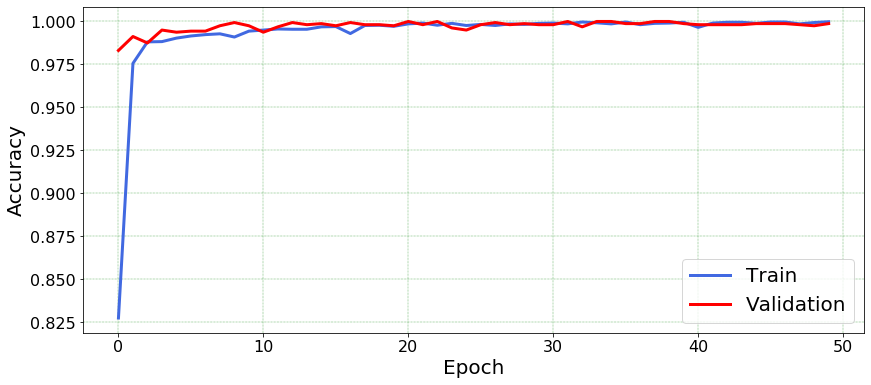

In [8]:
def printHistory(history):
       loss_curve = history.history["loss"]
       acc_curve = history.history["accuracy"]

       loss_val_curve = history.history["val_loss"]
       acc_val_curve = history.history["val_accuracy"]

       fig, axs = plt.subplots(figsize=(14,6))
       axs.plot(acc_curve, color='royalblue', alpha = 1, linewidth=3.0, label="Train")
       axs.plot(acc_val_curve, color='red', alpha = 1, linewidth=3.0, label="Validation")
       axs.set_ylabel('Accuracy', fontsize=20)
       axs.set_xlabel('Epoch', fontsize=20)
       axs.grid(color='g', ls = '-.', lw = 0.3)
       plt.xticks(fontsize = 16)
       plt.yticks(fontsize = 16)
       plt.legend(loc='lower right', fontsize=20)
       plt.show()
printHistory(history)

Load the model we just saved.

In [9]:
model_conv1D = load_model("E:/Spring2021/MnS4CPS/Final Project/conv1D_dymola_auto4000.h5")

Prepare real data from windfarm to test this ML model.

In [10]:
def prepareImportedDF(df):
       df['Timestamp'] = pd.to_datetime(df['Timestamp'])
       df['tmp'] = (df['Timestamp'].apply(lambda x: float(x.timestamp())) )
       df.insert(0, 'Timestamps', df['tmp'])
       df.drop(columns=['tmp'], inplace=True)
       df.sort_values(by=['Timestamps'], inplace=True)

OpenFile3 = r"E:\Spring 2020\Research\GridX\Training Datas\CSV files\New Folder\2018-05-15 02.50.59 Fort Smith Area_fixed.csv"
df3 = pd.read_csv(OpenFile3, header = 0, error_bad_lines=False)
prepareImportedDF(df3)

Prediction result on Real Data.

(22710, 27)
Processing Terminal MaudTap-Fixico 
 - Batch done for MaudTap-Fixico- 


E:\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


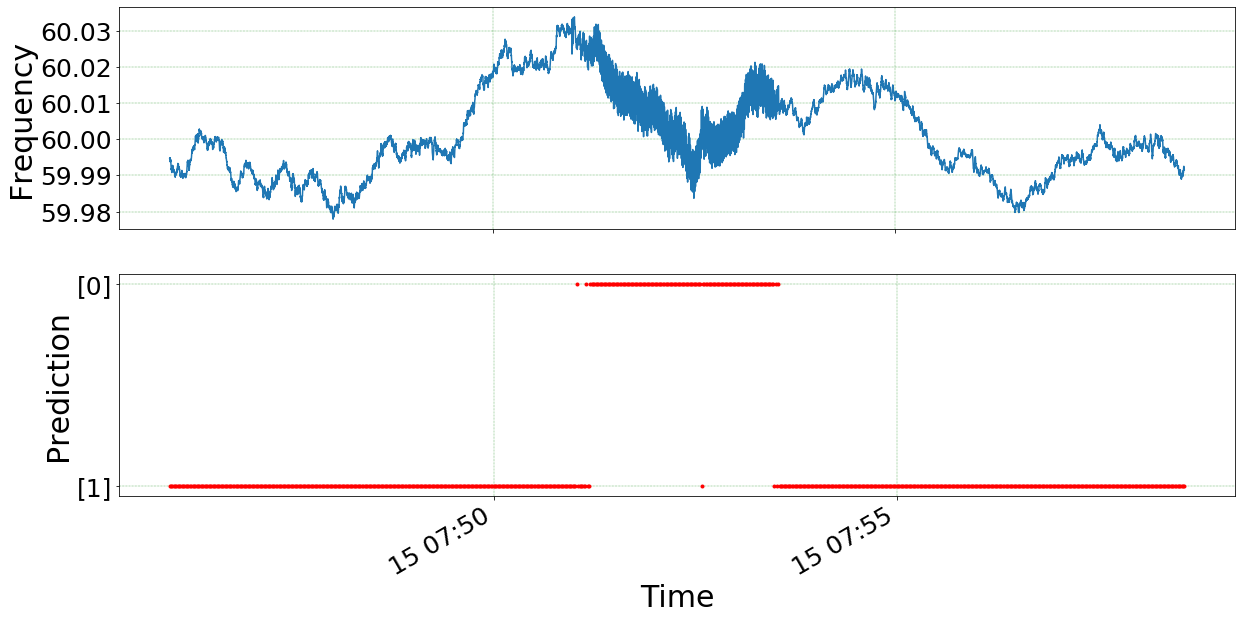

In [11]:
def slugify(value):
    valid_chars = "-_.() %s%s" % (string.ascii_letters, string.digits)
    return ''.join(c for c in value if c in valid_chars)

# This function is used to append one row of data to a csv file.
def writeLineToCSV(CSVfile, line):
       # 'a': Open a file for append. If the file already exists, the file pointer will be placed at the end of the file. That is, the new content will be written to the existing content. If the file does not exist, create a new file to write to.
       # If csvfile is a file object, it should be opened with newline=''. 
       file = open(CSVfile, 'a', newline='')
       with file:
              writer = csv.writer(file)
              writer.writerow(line.split(","))

def getNSec(datas, startDate, nbSEC):
       if startDate is None:
              startDate = datas["Timestamp"].values[0]
       r = datas[(datas["Timestamp"] >= pd.to_datetime(startDate))]
       endDate = pd.to_datetime(startDate) + timedelta(seconds = nbSEC)
       r = r[(r["Timestamp"] <= pd.to_datetime(endDate))]
       return r

def writeHeaderPredictionInCSV(filePath):
       header = 'Timestamp'
       header += ' Prediction'
       header = header.split()
       file = open(filePath, 'w', newline='')
       with file:
              writer = csv.writer(file)

              writer.writerow(header)

def ExportPrediction_Dense(model, datas, PlotNsecOfData = 1, SlidingWindowSec = 1, columnName = "Terminal", exportName =None, isDense = False):
    for g,k in datas.groupby('TermID'):
        dftmp = k
        StationName=slugify(str(dftmp[columnName].values[0]))
        if exportName is not None:
            StationName = exportName
        print(f"Processing Terminal {StationName} ")

        if not os.path.exists("E:/Spring 2020/Research/GridX/exports/Prediction"):
                os.makedirs("E:/Spring 2020/Research/GridX/exports/Prediction" )

        fileNameIN = "E:/Spring 2020/Research/GridX/exports/Prediction/" + StationName + ".csv"

        writeHeaderPredictionInCSV(fileNameIN)
        Datemax = pd.to_datetime(dftmp["Timestamp"].max())
        startAT = pd.to_datetime(dftmp["Timestamp"].values[0])

        while True:
                dataIN = getNSec(dftmp, startAT, PlotNsecOfData)

                if dataIN.shape[0] > 1:
                    data_tmp = dataIN["FREQ"].values

                    min_max_scaler = preprocessing.MinMaxScaler()
                    x_scaled = min_max_scaler.fit_transform(data_tmp.reshape(-1, 1)).reshape((1, 31))
                    #print(x_scaled)
                    #break
                    to_append = f'{startAT}' 
                    if isDense == True:
                        predictions = model.predict(x_scaled)   # THIS WORK FOR DENSE
                    else:
                        #X_train_LSTM = np.reshape(x_scaled, (x_scaled.shape[0], 1, x_scaled.shape[1]))   #THIS WORK FOR LSTM
                        X_train_LSTM = np.reshape(x_scaled, (x_scaled.shape[0], x_scaled.shape[1],1 ))  #THIS WORK FOR CONV1D
                        predictions = model.predict(X_train_LSTM)
                    #print(predictions)
                    resPrediction = np.argmax(predictions, axis=1)
                    #resPrediction =predictions[0]

                    to_append += f',{resPrediction}'
                    writeLineToCSV(fileNameIN, to_append)

                startAT += timedelta( seconds = SlidingWindowSec)
                
                if startAT + timedelta( seconds = PlotNsecOfData) > Datemax:
                    print(f" - Batch done for {StationName}- ")
                    break
                #break
        #break
        
def showModelPrediction_Dense(model, datas, terminalName, columnName = "Terminal", ignoreTerminalFilter = False, PlotNsecOfData = 1, SlidingWindowSec = 1, isDense = False):
       datas_tmp = datas
       if ignoreTerminalFilter is False:
        datas_tmp = datas[(datas[columnName]==terminalName)]
       
        print(datas_tmp.shape)
       ExportPrediction_Dense(model,datas_tmp, PlotNsecOfData = PlotNsecOfData, SlidingWindowSec = SlidingWindowSec, columnName = columnName, isDense = isDense)

       dataPredictions = pd.read_csv(f"E:/Spring 2020/Research/GridX/exports/Prediction/{terminalName}.csv", header = 0)
       dataPredictions['Timestamp'] = pd.to_datetime(dataPredictions['Timestamp'])

       fig, axs = plt.subplots(2, 1, figsize=(20,10), sharex=False)
       fig.autofmt_xdate()
       axs[0].plot(datas_tmp["Timestamp"],datas_tmp["FREQ"])
       axs[0].set_ylabel('Frequency', fontsize=30)
       axs[0].grid(color='g', ls = '-.', lw = 0.3)

       axs[1].plot(dataPredictions["Timestamp"],dataPredictions["Prediction"], "r.")
       axs[1].set_ylabel('Prediction', fontsize=30)
       axs[1].set_xlabel('Time', fontsize=30)
       axs[1].grid(color='g', ls = '-.', lw = 0.3)
       plt.xticks(fontsize = 25)
       plt.yticks(fontsize = 25)
       plt.sca(axs[0])
       plt.yticks(fontsize = 25)
       plt.show()

showModelPrediction_Dense(model_conv1D, df3, "MaudTap-Fixico")